In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import alpha

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [23]:
DATA_PATH = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [24]:
# 1. Загрузка и первичная очистка
def load_and_clean_data(path):
    df = pd.read_csv(path)

    # Исправляем TotalCharges: заменяем пробелы на NaN и конвертируем
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

    # удаляем строку tenure == 0 (новые клиенты без истории)
    df = df[df["tenure"] > 0].reset_index(drop=True)

    # Целевая переменная в числа
    df["Churn"] = (df["Churn"] == "Yes").astype(int)

    # Удаляем неимформативные колонки
    df = df.drop(["customerID"], axis=1)

    return df

df = load_and_clean_data(DATA_PATH)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [25]:
# 2. Feature Engineering

class TelecomFeatureEngineering(BaseEstimator, TransformerMixin):
    '''Трансформер для создания кастомных признаков.
    Позволяет пайплайну автоматически обрабатывать новые данные.'''

    def __init__(self):
        self.service_cols = [
            "OnlineSecurity", "OnlineBackup", "DeviceProtection",
            "TechSupport", "StreamingTV", "StreamingMovies"
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Группируем сервисы: No internet service -> No
        for col in self.service_cols:
            X[col] = X[col].replace("No internet service", "No")

        X["TotalServices"] = X[self.service_cols].apply(lambda row: (row == "Yes").sum(), axis=1)

        X["is_new_client"] = (X["tenure"] < 6).astype(int)

        if "TotalCharges" in X.columns:
            X = X.drop(["TotalCharges"], axis=1)

        return X


In [26]:
# 3. Preprocessing
num_features = ["tenure", "MonthlyCharges", "TotalServices"]
cat_features = ["Contract", "PaymentMethod", "InternetService", "SeniorCitizen"]
bin_features = ["Partner", "Dependents", "PaperlessBilling", "PhoneService", "MultipleLines"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
        ("bin", OneHotEncoder(drop="if_binary"), bin_features),
    ]
)

In [27]:
# 4. Сборка и обучние модели
full_pipeline = Pipeline(
    [
        ("feature_eng", TelecomFeatureEngineering()),
        ("preprocessor", preprocessor),
        ('classifier', LogisticRegression(class_weight="balanced", random_state=42)),
    ]
)

X = df.drop("Churn", axis=1)
y = df.Churn

X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

full_pipeline.fit(X_trian, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different

In [28]:
# 5. Оценка результатов
y_pred = full_pipeline.predict(X_test)
y_proba = full_pipeline.predict_proba(X_test)[:, 1]

print("Отчет классификации")
print(classification_report(y_test, y_pred))
print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

# проверка стабильности через кросс-валидацию
cv_auc = cross_val_score(full_pipeline, X_trian, y_train, cv=5, scoring="roc_auc")
print(f"CV ROC-AUC: {cv_auc.mean():.4f} +/- {cv_auc.std():.4f}")


Отчет классификации
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1033
           1       0.49      0.77      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407

ROC_AUC: 0.8346
Confusion Matrix
[[731 302]
 [ 86 288]]
CV ROC-AUC: 0.8422 +/- 0.0182


In [29]:
# 6. Feature Selection. Оставим только те признаки, которые релаьно влияют на результат.
from sklearn.feature_selection import SelectFromModel

full_pipeline = Pipeline(
    [
        ("feature_eng", TelecomFeatureEngineering()),
        ("preprocessor", preprocessor),
        ('feature_selection', SelectFromModel(
    LogisticRegression(solver='liblinear', l1_ratio=1.0, class_weight='balanced', random_state=42))),
        ('classifier', LogisticRegression(class_weight="balanced", random_state=42)),
    ]
)

X = df.drop("Churn", axis=1)
y = df.Churn

X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

full_pipeline.fit(X_trian, y_train)


y_pred = full_pipeline.predict(X_test)
y_proba = full_pipeline.predict_proba(X_test)[:, 1]

print("Отчет классификации")
print(classification_report(y_test, y_pred))
print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

# проверка стабильности через кросс-валидацию
cv_auc = cross_val_score(full_pipeline, X_trian, y_train, cv=5, scoring="roc_auc")
print(f"CV ROC-AUC: {cv_auc.mean():.4f} +/- {cv_auc.std():.4f}")

Отчет классификации
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1033
           1       0.49      0.77      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407

ROC_AUC: 0.8346
Confusion Matrix
[[731 302]
 [ 86 288]]
CV ROC-AUC: 0.8421 +/- 0.0182


In [30]:
# Достаем названия колонок после препроцессора
features_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Достаем маску отобранных признаков
selected_mask = full_pipeline.named_steps['feature_selection'].get_support()

# Финальные признаки
final_features = features_names[selected_mask]

# Коэффициенты модели
coefs = full_pipeline.named_steps['classifier'].coef_[0]

# Создаем красивую таблицу
importance_df = pd.DataFrame({'feature': final_features, 'coef': coefs})
importance_df['abs_coef'] = importance_df['coef'].abs()
print(importance_df.sort_values(by='abs_coef', ascending=False))

                                       feature      coef  abs_coef
1                          num__MonthlyCharges  1.847689  1.847689
4                       cat__Contract_Two year -1.475106  1.475106
16         bin__MultipleLines_No phone service  1.006585  1.006585
9                      cat__InternetService_No  0.827514  0.827514
3                       cat__Contract_One year -0.790022  0.790022
2                           num__TotalServices -0.773399  0.773399
0                                  num__tenure -0.755190  0.755190
14                       bin__PhoneService_Yes -0.734153  0.734153
8             cat__InternetService_Fiber optic -0.519515  0.519515
6          cat__PaymentMethod_Electronic check  0.441149  0.441149
13                   bin__PaperlessBilling_Yes  0.285409  0.285409
12                         bin__Dependents_Yes -0.244080  0.244080
10                        cat__SeniorCitizen_1  0.221907  0.221907
7              cat__PaymentMethod_Mailed check  0.086379  0.08

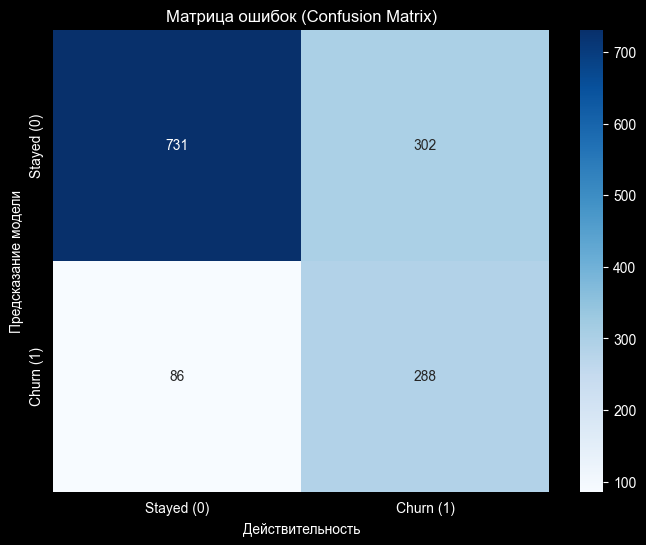

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=["Stayed (0)", "Churn (1)"],
            yticklabels=["Stayed (0)", "Churn (1)"])
plt.xlabel("Действительность")
plt.ylabel("Предсказание модели")
plt.title("Матрица ошибок (Confusion Matrix)")

plt.savefig("../results/confusion_matrix.png", dpi=300, bbox_inches="tight")

plt.show()

In [32]:
friendly_names = {
    "num__tenure": "Длительность пользования",
    "num__MonthlyCharges": "Ежемесячный платеж",
    "num__TotalServices": "К-во подключенных услуг",
    "cat__Contract_One year": "Контракт на 1 год",
    "cat__Contract_Two year": "Контракт на 2 года",
    "cat__PaymentMethod_Credit card (automatic)": "Оплата: картой (автооплата)",
    "cat__PaymentMethod_Electronic check": "Оплата: электронный чек",
    "cat__PaymentMethod_Mailed check": "Оплата: чек по почте",
    "cat__InternetService_Fiber optic": "Тип: Оптоволокно",
    "cat__InternetService_No": "Нет интернета",
    "cat__SeniorCitizen_1": "Пожилой возраст",
    "bin__Partner_Yes": "Есть партнер",
    "bin__Dependents_Yes": "Есть иждивенцы",
    "bin__PaperlessBilling_Yes": "Безналичный расчёт",
    "bin__PhoneService_Yes": "Наличие телефона",
    "bin__MultipleLines_No": "Нет линий",
    "bin__MultipleLines_No phone service": "Несколько телефонных линий",
}
importance_df["feature_friendly"] = importance_df["feature"].map(friendly_names).fillna(importance_df["feature"])

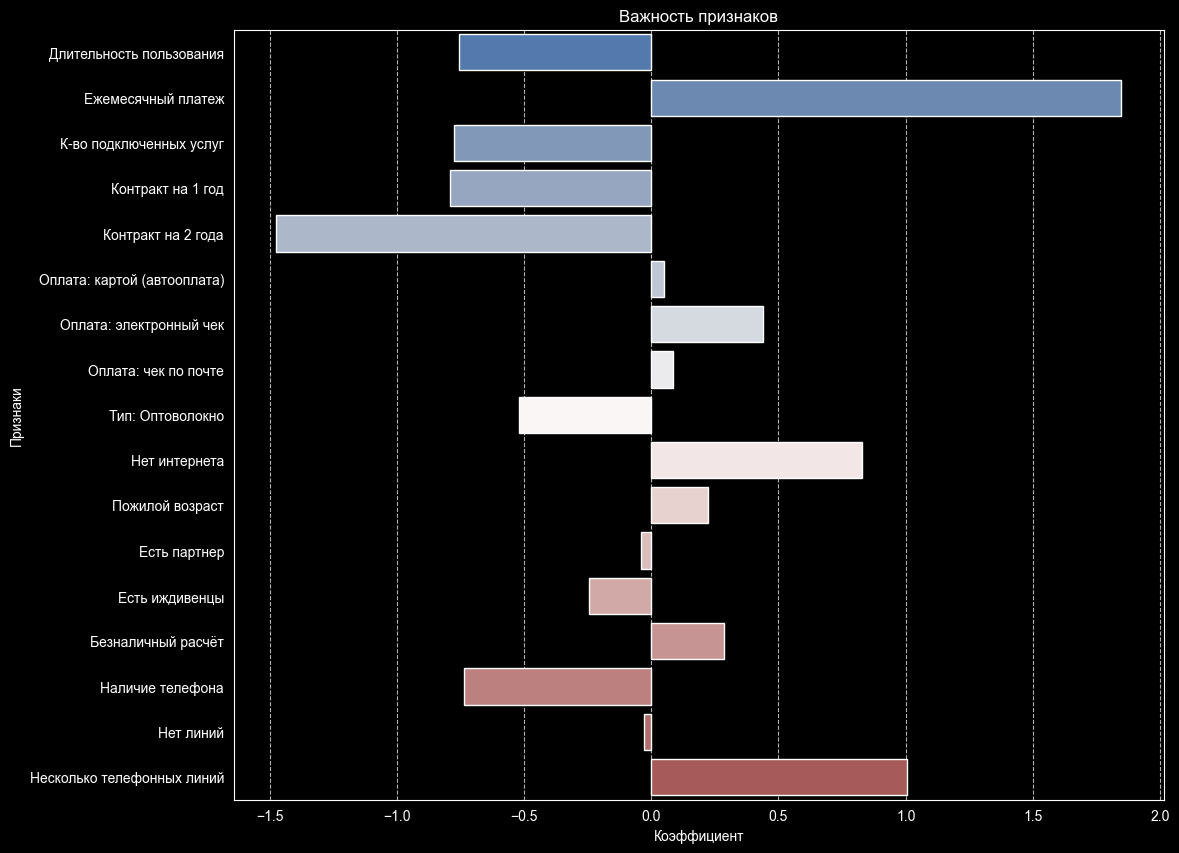

In [33]:
plt.figure(figsize=(12, 10))
sns.barplot(
    x="coef",
    y="feature_friendly",
    data=importance_df,
    hue="feature",     # Добавляем привязку цвета к фиче
    palette="vlag",
    legend=False       # Убираем легенду, чтобы она не мешала
)
plt.title("Важность признаков")
plt.ylabel("Признаки")
plt.xlabel("Коэффициент")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.savefig("../results/importance.png", dpi=300, bbox_inches="tight")
plt.show()

### Выводы

1. Оценка качества модели
    - Высокая разделяющая способность: ROC-AUC 0.835 (и стабильные 0.842 на кросс-валидации) говорят о том, что модель очень качественно ранжирует клиентов по степени риска. Она эффективно отличает потенциальных "беглецов" от лояльных пользователей.
    - Баланс удержания (Recall): Мы добились Recall 0.77 для целевого класса. Это означает, что модель индентифицирует 77% всех клиентов, которые реально собираются уйти. Это позволяет предотвратить потерю большей чатсти уходящей выручки.

2. Анализ матрицы ошибок
    - 288 спасенных: Мы вовремя нашли этих людей. Если предложить им персональную скидку или бонус, компания сохранит их подписки.
    - 86 упущенных: Столько клиентов ушли незамеченными.
    - 302 ложных тревоги: Этим лояльным клиентам мы тоже можем по ошибке предложить удержание. Хотя это несет затраты, они значительно ниже, чем стоимость потери реального клиента.

3. Ключевые факторы оттока
    1. Ежемесячные траты: Самый сильный фактор. Чем выше чек, тем чувствительнее клиент к конкурентным предложениям.
    2. Отсутствие стационарного телефона: Клиенты без телефонной линии уходят чаще.
    3. Электронные чеки и бумажная оплата: Использование этих методов ассоциируется с более высоким риском (возможно, из-за простоты смены провайдера в цифровом формате).
    4. Тип контракта: Долгосрочные контракты - "фундамент" лояльности. Они снижают риск ухода практически вдвое по сравнению с помесячной оплатой.
    5. Комплексность услуг: Чем больше доп.услуг подключено, тем "лояльнее" становится клиент.
    6. Срок жизни: Каждый месяц сотрудничества снижает вероятность оттока. Самый опасный период - первые 6 месяцев.

In [34]:
def calculate_business_profit(y_test, y_pred, ltv=500, retention_cost=20, p_success=0.7):
    '''
    ltv: Сколько прибыли приносит клиент (Lifetime Value)
    retention_cost: Стоимость удержания одного клиента (бонус, скидка)
    p_success: Вероятность, что клиент останется после получения бонуса
    '''
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1] # Нашли и удержали (пытаемся)
    fp = cm[0, 1] # Ошиблись (потратили деньги зря)
    fn = cm[1, 0] # Пропустили (клиент ушел)

    # Доход от спасенных клиентов
    revenue_saved = tp * p_success * ltv

    # Затраты на компанию по удержанию
    total_retention_costs = (tp + fp) * retention_cost

    # Итоговая прибыль
    model_profit = revenue_saved - total_retention_costs

    # Убытки без модели
    losses_without_model = (tp + fn) * ltv

    return {
        "Чистая прибыль от модели": model_profit,
        "Затраты на удержание (впустую)": fp * retention_cost,
        "Спасенная выручка": revenue_saved,
        "Потенциальные убытки без модели": losses_without_model,
    }

In [35]:
results = calculate_business_profit(y_test, y_pred, ltv=1164.36, p_success=0.7, retention_cost=29.11)
for key, value in results.items():
    print(f"{key}: ${value:,.0f}")

Чистая прибыль от модели: $217,560
Затраты на удержание (впустую): $8,791
Спасенная выручка: $234,735
Потенциальные убытки без модели: $435,471
